In [31]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
from astropy.table import Table

### get MnI EW from HARPS data:

In [5]:
# Get list of all HARPS Files
harps_files = glob('./SolarData/HARPS_wBlaze/*.fits')
print(f'Number of HARPS Files: {len(harps_files)}')

Number of HARPS Files: 7130


In [6]:
def fit_line(x, y, n_iter=3, sigma=1.):
    A = np.vstack([x, np.ones(len(x))]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    
    clip = np.isnan(y)
    for i in range(n_iter):
        y_norm = y - (m*x + b)
        clip = np.abs(y_norm - np.mean(y_norm)) >= sigma * np.std(y_norm[~clip]) 
        A = np.vstack([x[~clip], np.ones(len(x[~clip]))]).T
        m, b = np.linalg.lstsq(A, y[~clip], rcond=None)[0]
            
        #plt.plot(x, y_norm)

    return m, b

def gauss(x, A, B, C, c):
    return A*np.exp(-(x-B)**2/(2*C**2)) + c

def gauss_w_line(x, A, B, C, b, m):
    return A*np.exp(-(x-B)**2/(2*C**2)) + b + m*x  

def fit_gaussian(x, y):
    A0, B0, C0, c0 = -0.4, 5396.15, 0.1, 1.
    popt = curve_fit(gauss, x, y, p0=(A0, B0, C0, c0), full_output=True)
    return popt[0]

def fit_gaussian_w_line(x, y):
    m0, b0 = fit_line(x, y)
    A0, B0, C0, c0 = -0.4, 5396.15, 0.1, 1.
    x_mask = (x >= 5396.6) & (x <= 5396.85)
    popt = curve_fit(gauss_w_line, x[~x_mask], y[~x_mask], p0=(A0, B0, C0, b0, m0), full_output=True)
    return popt[0]

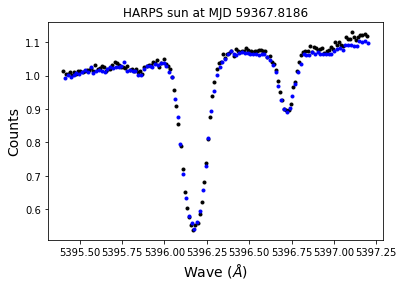

In [7]:
hdus = fits.open(harps_files[0])
harps_wave = hdus['wavedata_vac_bary'].data.copy()
harps_spec = hdus['scidata'].data.copy()
harps_errs = hdus['errdata'].data.copy()
time = hdus[0].header['MJD-OBS']
hdus.close()

ind1 = (harps_wave[45] >= 5395.4) & (harps_wave[45] <= 5397.2)
m,b = fit_line(harps_wave[45][ind1], harps_spec[45][ind1])
continuum = m * harps_wave[45][ind1] + b
plt.plot(harps_wave[45][ind1], harps_spec[45][ind1] / continuum, 'k.')
x, y = harps_wave[45][ind1], harps_spec[45][ind1] / continuum


ind2 = (harps_wave[46] >= 5395.4) & (harps_wave[46] <= 5397.2)
m,b = fit_line(harps_wave[46][ind2], harps_spec[46][ind2])
continuum = m * harps_wave[46][ind2] + b
plt.plot(harps_wave[46][ind2], harps_spec[46][ind2] / continuum, 'b.')
plt.xlabel(r'Wave ($\AA$)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('HARPS sun at MJD {0:.4f}'.format(time), fontsize=12);

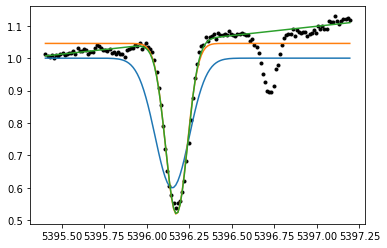

In [8]:
A0, B0, C0, c0 = -0.4, 5396.15, 0.1, 1.

plt.plot(x,y, 'k.')
plt.plot(x, gauss(x, A0, B0, C0, c0))
#plt.axvline(5396.6)
#plt.axvline(5396.85)


popt = curve_fit(gauss, x, y, p0=(A0, B0, C0, c0), full_output=True)
par = popt[0]
plt.plot(x, gauss(x, *par))

par = fit_gaussian_w_line(x, y)
plt.plot(x, gauss_w_line(x, *par));

In [22]:
times = np.empty(len(harps_files))
rvs = np.empty_like(times)
eqws = np.empty(len(harps_files))
amps = np.empty_like(eqws)
centers = np.empty_like(eqws)
sigmas = np.empty_like(eqws)
slopes = np.empty_like(eqws)
offsets = np.empty_like(eqws)


for i,file in tqdm(enumerate(harps_files)):
    with fits.open(file) as hdus:
        harps_wave = hdus['wavedata_vac_bary'].data.copy()
        harps_spec = hdus['scidata'].data.copy()
        harps_errs = hdus['errdata'].data.copy()
        time = hdus[0].header['MJD-OBS']
        rv = hdus[0].header['HIERARCH ESO QC CCF RV']
    times[i] = time
    rvs[i] = rv

    ind1 = (harps_wave[45] >= 5395.4) & (harps_wave[45] <= 5397.2)
    m,b = fit_line(harps_wave[45][ind1], harps_spec[45][ind1])
    continuum = m * harps_wave[45][ind1] + b
    x, y = harps_wave[45][ind1], harps_spec[45][ind1] / continuum
    
    par = fit_gaussian_w_line(x, y)
    gauss_area = np.sqrt(2*np.pi) * par[0] * np.abs(par[2])
    gauss_center = par[-2] + par[-1] * par[1] # value of continuum line at Gaussian center
    eqw = -gauss_area / gauss_center
    eqws[i] = eqw
    amps[i] = par[0]
    centers[i] = par[1]
    sigmas[i] = par[2]
    slopes[i] = par[3]
    offsets[i] = par[4]

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

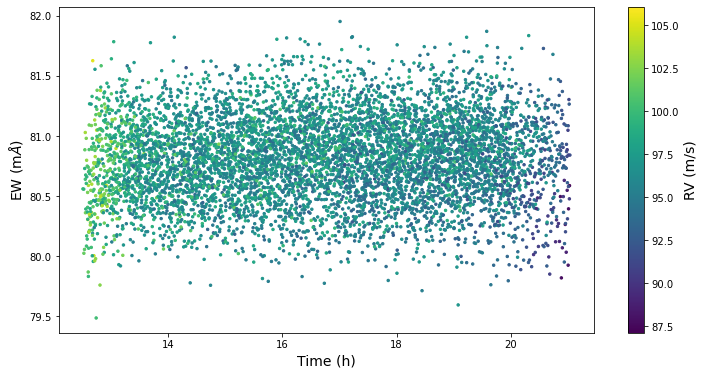

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.scatter((times % 1.) * 24., eqws * 1.e3, c=rvs * 1.e3, s=6)
cbar = plt.colorbar()
cbar.set_label(label='RV (m/s)',size=14)
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel(r'EW (m$\AA$)', fontsize=14)
plt.savefig('eqw_day.png');

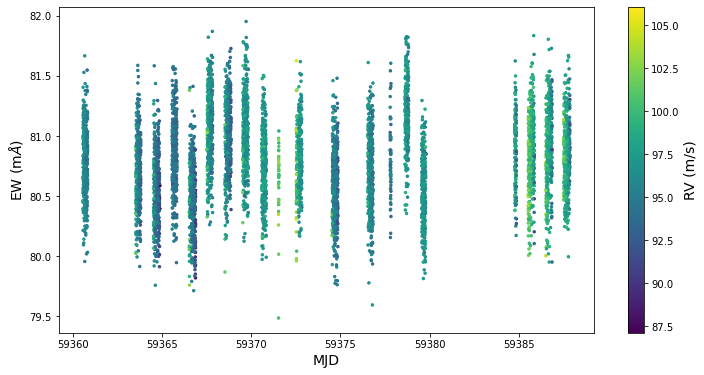

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(times, eqws * 1.e3, c=rvs * 1.e3, s=6)
cbar = plt.colorbar()
cbar.set_label(label='RV (m/s)',size=14)
plt.xlabel('MJD', fontsize=14)
plt.ylabel(r'EW (m$\AA$)', fontsize=14)
plt.savefig('eqw.png');

In [35]:
t = Table()
t['MJD'] = times
t['RV'] = rvs
t['filename'] = harps_files
t['EQW'] = eqws
t['gauss_center'] = centers
t['gauss_amp'] = amps
t['gauss_sigma'] = sigmas
t['line_slope'] = slopes
t['line_offsets'] = offsets
t.write('HARPS_MnI_order45.csv')

### compare to other measured quantities in the HARPS spectra:

In [53]:
metadata = Table.read('SolarData/ProvidedDataFiles/221019_harps_drp.csv')
metadata.columns

<TableColumns names=('file_root','night','jdb','jdn','vrad','vrad_corr','svrad','noise','vrad_heli','berv_corr','diff_ext_corr','berv','berv_corr_1','fwhm','fwhm_corr','sfwhm','contrast','contrast_corr','scontrast','bis_span','sbis_span','sn20','sn50','sn60','sn_CaII','s_mw','sig_s','rhk','sig_rhk','airmass','ha','alpha','delta','texp','th_error','lamp_offset','flux_corr_min','flux_corr_max','extinction','qualflag')>

In [43]:
t['file_root'] = [filename.split('r.')[-1].split('_S2D')[0] for filename in t['filename']]

In [52]:
from astropy.table import join
t = join(t, metadata, join_type='inner')

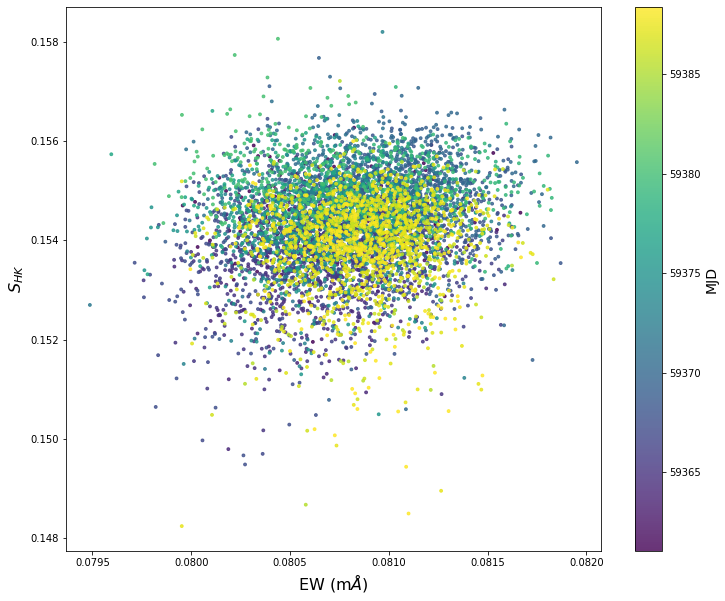

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plt.scatter(t['EQW'], t['s_mw'], c=t['jdb'], s=8, alpha=0.8)
cbar = plt.colorbar()
cbar.set_label(label='MJD',size=14)
plt.ylabel(r'$S_{HK}$', fontsize=16)
plt.xlabel(r'EW (m$\AA$)', fontsize=16);

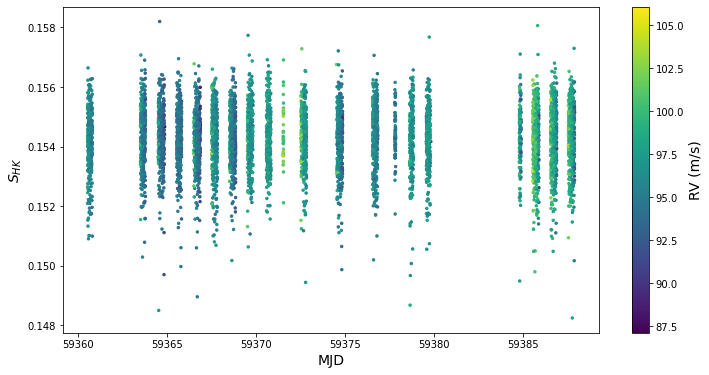

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(times, t['s_mw'], c=rvs * 1.e3, s=6)
cbar = plt.colorbar()
cbar.set_label(label='RV (m/s)',size=14)
plt.xlabel('MJD', fontsize=14)
plt.ylabel(r'$S_{HK}$', fontsize=14);
#plt.savefig('shk.png');